<a href="https://colab.research.google.com/github/FaithOmoh/my_repo/blob/main/Bias_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install aif360

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.1/214.1 kB 2.3 MB/s eta 0:00:00


In [2]:
!pip install aif360[Reductions]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 2.6 MB/s eta 0:00:00


In [3]:
!pip install aif360[LawSchoolGPA]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.1 MB/s eta 0:00:00


# Background

The code demonstrates a process for assessing and mitigating bias in a machine learning model, specifically with respect to a protected attribute (in this case, 'sex'). The dataset used is the Adult dataset from the UCI Machine Learning Repository, which contains information about individuals, such as age, workclass, education, marital status, occupation, race, sex, and income.

The code utilizes the AI Fairness 360 (AIF360) toolkit, which provides functionality for measuring and mitigating bias in machine learning models. The focus is on the 'sex' attribute, and the code demonstrates steps to evaluate and enhance fairness in predictions, especially concerning disparate impact. The methods used include Reweighing and Adversarial Debiasing, showcasing techniques for responsible AI development.


In [15]:
# We import necessary libaries
!pip install aif360
!pip install aif360[Reductions]
!pip install aif360[LawSchoolGPA]
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
import tensorflow.compat.v1 as tf

# import warnings; warnings.simplefilter('ignore')

%matplotlib inline


### Tensorflow configuration
To ensure a clean and compatible TensorFlow environment, which can be crucial when working with complex machine learning models, especially those involving external libraries or older TensorFlow features. We need to clear the TensorFlow Keras session which follows with disabling eager execution and reverts to the graph execution mode.

In [7]:
# clear the tensorflow keras session
tf.keras.backend.clear_session()


# Disable eager execution
tf.compat.v1.disable_eager_execution()

   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

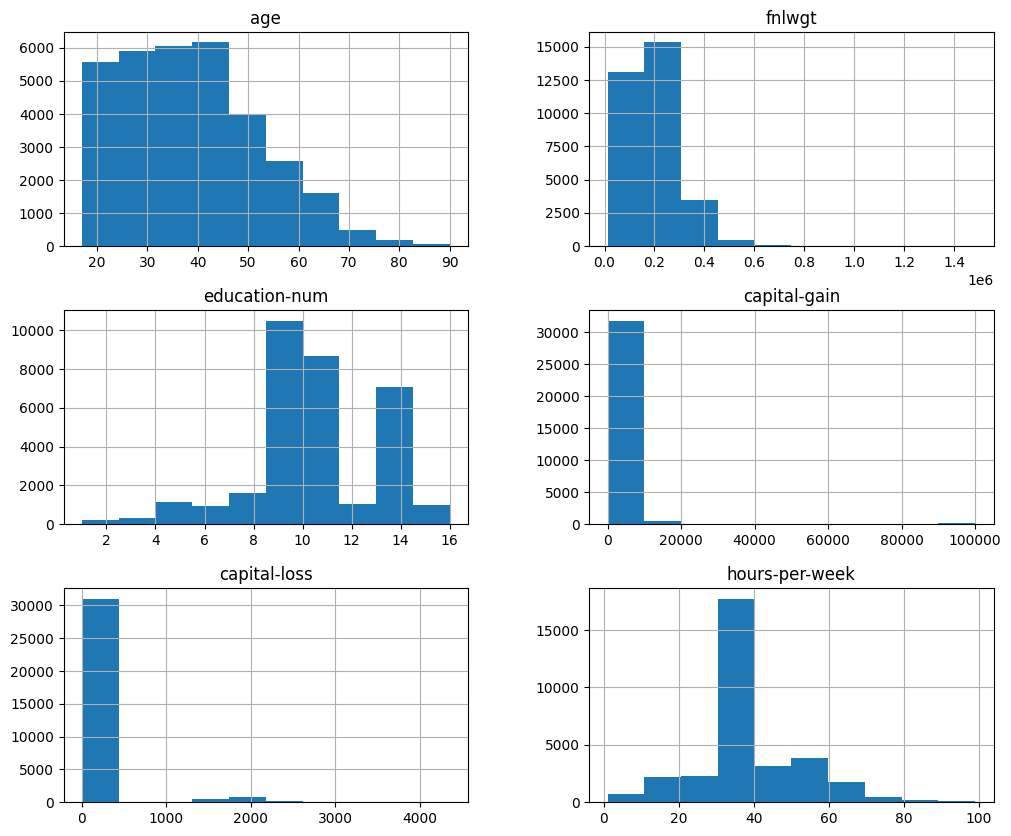

<ipython-input-16-c88e336c0266>:19: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm')


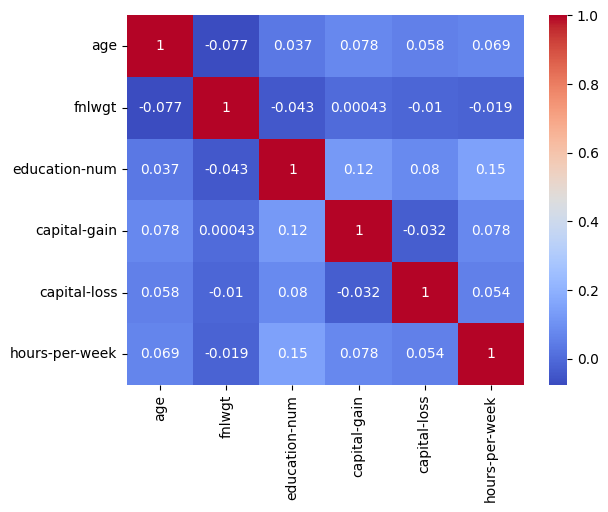

In [16]:
# Load the Adult dataset from UCI Machine Learning Repository
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
                'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
dataset = pd.read_csv(url, header=None, names=column_names, na_values=' ?', skipinitialspace=True)

# Let's Explore the dataset
print(dataset.head())
print(dataset.info())

# Descriptive statistics
print(dataset.describe())

# Visualize the distribution of numerical features
dataset.hist(figsize=(12, 10))
plt.show()

# Visualize the correlation matrix
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm')
plt.show()


## Handling the Data structure
In the context of machine learning, categorical variables are those that can take on a limited, fixed number of values. These variables can be nominal (categories with no inherent order) or ordinal (categories with a meaningful order). Before using categorical variables in a machine learning model, they need to be encoded into a numerical format, as most machine learning algorithms operate on numerical data.

The original categorical variables in the dataset, such as 'workclass,' 'education,' 'marital-status,' 'occupation,' 'relationship,' 'race,' and 'native-country,' are converted into numerical representations.

We then use an encoding technique known as "one-hot encoding", where binary columns are created for each category, and the presence or absence of a category is represented by 0s and 1s.

Furthermore, we then convert the 'sex' column into a binary format. In this case, the 'sex' column is converted into a binary representation where 'Female' is encoded as 1 and 'Male' as 0, or vice versa. This binary representation is often preferred for binary classification tasks, where machine learning models predict outcomes with two possible values. The binarization simplifies the representation of gender, making it compatible with algorithms that require numerical input.

In [17]:
# Assume 'sex' is the protected attribute
protected_attribute = 'sex'

# Drop missing values for simplicity
dataset = dataset.dropna()

# Encode categorical variables
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
dataset_encoded = pd.get_dummies(dataset, columns=categorical_columns)

# Encode 'sex' column
dataset_encoded['sex'] = dataset_encoded['sex'].apply(lambda x: 1 if x.strip() == 'Female' else 0)

# Encode 'income' column
label_encoder = LabelEncoder()
dataset_encoded['income'] = label_encoder.fit_transform(dataset_encoded['income'])

# Splitting data into features and labels
X = dataset_encoded.drop('income', axis=1)
y = dataset_encoded['income']

# Splitting data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a BinaryLabelDataset
test_dataset = BinaryLabelDataset(df=pd.concat([X_test, y_test], axis=1),
                                   label_names=['income'], protected_attribute_names=[protected_attribute])


## The Bias Assessment
The all point of this technique is to evaluate the fairness of a machine learning model using the Disparate Impact metric, the machine learning model for case study here is the Random Forest classifier.

The bias assessment aims to identify and quantify any disparate impact that the machine learning model may exhibit across different subgroups, especially concerning sensitive attributes. It provides insights into whether the model's predictions are fair and unbiased across different demographic or protected attribute groups.

The following are steps involved in this assessment:


1. Training the Model: The Random Forest model is trained on a training dataset. During training, the model learns patterns and relationships in the data to make predictions.
2. Making Predictions: After the model is trained, it is used to make predictions on a separate dataset known as the test set. The test set is a collection of data that the model has not seen during training, and it serves as a proxy for real-world scenarios.
3. Assessing Bias: The Disparate Impact metric is then calculated on the predictions made by the model on the original test dataset. Disparate Impact is a measure of the disparate treatment of different groups in the dataset, often with respect to protected attributes like gender or race. It quantifies whether there are differences in predictions between the groups, and it can indicate potential bias in the model's behavior.

In [18]:
# Train a machine learning model (Random Forest as an example)
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Assess bias in the model
metric = BinaryLabelDatasetMetric(test_dataset, unprivileged_groups=[{protected_attribute: 0}],
                                  privileged_groups=[{protected_attribute: 1}])
print("Original Dataset - Disparate Impact (DI):", metric.disparate_impact())


Original Dataset - Disparate Impact (DI): 2.782888577351539


## Mitigating Bias
Mitigating bias in machine learning refers to the process of reducing or eliminating unfair disparities in model predictions across different groups, particularly concerning protected attributes such as gender or race.

In this code the bias mitigation involves adjusting the dataset to ensure that the machine learning model's predictions are fair and unbiased across different subgroups. The Reweighing technique is one approach to achieve this, is a preprocessing technique designed to adjust the weights of instances in the dataset, aiming to ensure fair treatment across different groups and assessing bias both before and after the mitigation step helps gauge the impact of the mitigation strategy.

The original dataset is transformed using the Reweighing technique. This transformation involves adjusting the weights assigned to instances, typically based on the protected attribute, to create a reweighted dataset.

After the dataset is reweighted, bias assessment is performed again on this modified dataset. The Disparate Impact metric is likely recalculated to evaluate whether the reweighing process has effectively reduced bias in the model predictions. Comparing the Disparate Impact before and after reweighing provides insights into the effectiveness of the mitigation strategy.

In [19]:
# Mitigate bias using Reweighing
preprocessor = Reweighing(unprivileged_groups=[{protected_attribute: 0}],
                           privileged_groups=[{protected_attribute: 1}])
dataset_reweighted = preprocessor.fit_transform(test_dataset)

# Assess bias in the reweighted dataset
metric = BinaryLabelDatasetMetric(dataset_reweighted, unprivileged_groups=[{protected_attribute: 0}],
                                  privileged_groups=[{protected_attribute: 1}])
print("Reweighted Dataset - Disparate Impact (DI):", metric.disparate_impact())


Reweighted Dataset - Disparate Impact (DI): 1.0000000000000002


## Debiasing Model
The debiasing model seeks to enhance fairness by training a model to make predictions that are less influenced by protected attributes, and the evaluation is done by assessing bias in the predictions on a debiased dataset. The steps carried out in this code involves:

1. Training an Adversarial Debiasing Model: An adversarial debiasing model is a type of model designed to reduce biases in machine learning datasets During training, the model is exposed to the original dataset and learns to minimize the impact of protected attributes (features that could introduce bias) on predictions. The goal is to make the model less sensitive to factors like gender or race, promoting fairness.
2. Making Predictions on the Test Dataset: Once the adversarial debiasing model is trained, it is applied to the test dataset to generate predictions. These predictions are made with the intention of reducing biases that may exist in the original model's predictions, particularly regarding the protected attributes.
3. Assessing Bias on the Debiased Dataset: After obtaining predictions from the debiasing model, the final step involves assessing bias on the debiased dataset. Various metrics, such as Disparate Impact, can be used to evaluate the fairness of the model's predictions across different groups defined by the protected attributes. The aim is to observe whether the debiasing process has effectively reduced or mitigated biases in comparison to the original model.

In [20]:
# Train a debiased model using Adversarial Debiasing
debias_model = AdversarialDebiasing(unprivileged_groups=[{protected_attribute: 0}],
                                    privileged_groups=[{protected_attribute: 1}],
                                    scope_name="debiased_model",
                                    sess=None)
# Explicitly create a TensorFlow session
sess = tf.Session()
debias_model.sess = sess
sess.run(tf.global_variables_initializer())

# Fit the debiasing model
debias_model.fit(test_dataset)

# Now, we run predict to get the debiased dataset
dataset_debiased = debias_model.predict(test_dataset)

# Assess bias in the debiased dataset
metric = BinaryLabelDatasetMetric(dataset_debiased, unprivileged_groups=[{protected_attribute: 0}],
                                  privileged_groups=[{protected_attribute: 1}])
print("Debiased Dataset - Disparate Impact (DI):", metric.disparate_impact())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 8442.673828; batch adversarial loss: 0.965042
epoch 1; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 2; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 3; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 4; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 5; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 6; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 7; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 8; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 9; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 10; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 11; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 12; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 13; iter: 0; bat

/usr/local/lib/python3.10/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)


## RESULT EVALUATION
A Disparate Impact (DI) value DI = 1.0: Suggests that there is no disparate impact on the model and that the model's predictions do not show a significant difference in impact between the privileged and unprivileged groups. In an ideal scenario, DI is close to 1.0, indicating fairness. In practice, a DI close to 1.0 is considered desirable as it indicates a more equitable distribution of outcomes across different groups.

A Disparate Impact (DI) value DI < 1.0: Indicates disparate impact, but in the opposite direction, meaning that there is a significant difference in the model's impact on the privileged and unprivileged groups. In this case, with DI being less than 1.0, the impact on the privileged group is disproportionately higher compared to the unprivileged group. For example, if DI is 0.5, it means that the model's impact on the unprivileged group is half of the impact on the privileged group. This situation can also indicate bias or unfairness in the model, but it is manifesting in favor of the privileged group.

A Disparate Impact (DI) value DI > 1.0: Also suggests disparate impact, meaning that there is a significant difference in the model's impact on the privileged and unprivileged groups. In this case, with DI being greater than 1.0, the impact on the unprivileged group is disproportionately higher compared to the privileged group.

In either case (DI > 1.0 or DI < 1.0) indicates disparate, the goal of fairness-aware machine learning is often to mitigate disparate impact and bring the DI closer to 1.0, indicating a more equitable distribution of outcomes across different groups defined by the protected attribute.

In the first result, a DI value of 2.782888577351539 indicates that the original model's predictions have a substantial disparate impact, potentially indicating bias or unfairness in how the model treats different groups defined by the protected attribute. To address such issues, we used the technique of reweighing which can be applied to reduce disparate impact and promote fairness in the model's predictions. The goal is often to bring the DI closer to 1.0, indicating a more equitable distribution of outcomes across different groups.

The second result provided us with the reweighted dataset's DI value, which was close to 1.0 it suggests that the Reweighing technique has been effective in reducing disparate impact and promoting fairness in the model's predictions across the protected attribute groups.
